In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
train_mask=[i for i in os.listdir("C:/Users/KIIT/Downloads/Konnections/My model/dataset/with_mask/")]
train_nomask=[i for i in os.listdir("C:/Users/KIIT/Downloads/Konnections/My model/dataset/without_mask/")]

In [3]:
train_mask[:5]

['0_0_0 copy 10.jpg',
 '0_0_0 copy 11.jpg',
 '0_0_0 copy 12.jpg',
 '0_0_0 copy 13.jpg',
 '0_0_0 copy 14.jpg']

In [4]:
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg19 import preprocess_input
import cv2
def read_and_process_img(imgset,name):
    dirr=r"C:/Users/KIIT/Downloads/Konnections/My model/dataset/"
    X=[]
    y=[]
    undetected=[]
    for img in imgset:
        if img is not None:
            try:
                img=load_img(dirr+name+"/"+img,target_size=(224,224))
                
                img=img_to_array(img) #or we can use cv2
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #img=np.expand_dims(img,axis=0)
                img=preprocess_input(img)
                X.append(img)
                if name=='with_mask':
                    y.append('with_mask')
                else:
                    y.append('without_mask')
            except:
                undetected.append(img)
                
    print("Undetected images - ",len(undetected))
    return X,y

In [5]:
train_mask,label1=read_and_process_img(train_mask,'with_mask')

C:\Users\KIIT\anaconda3\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Undetected images -  0


In [6]:
train_nomask,label2=read_and_process_img(train_nomask,'without_mask')

Undetected images -  0


In [7]:
len(train_nomask)

1918

In [8]:
len(train_mask)

1915

In [9]:
train_set=train_mask+train_nomask
labels=label1+label2
r=random.random()
random.shuffle(train_set,lambda : r)#using same function for both to make shuffle order same
random.shuffle(labels,lambda : r)

In [10]:
del train_mask,train_nomask

In [11]:
labels[2:20]

['with_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'with_mask',
 'without_mask',
 'with_mask',
 'without_mask',
 'with_mask']

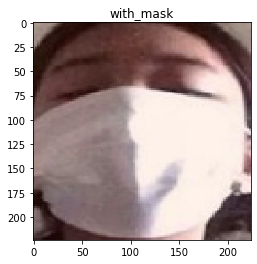

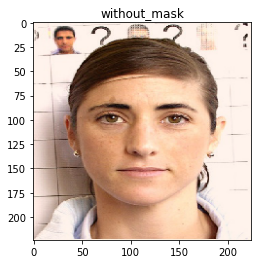

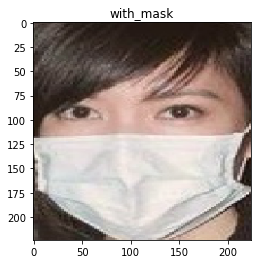

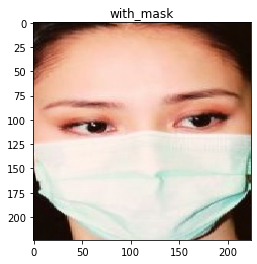

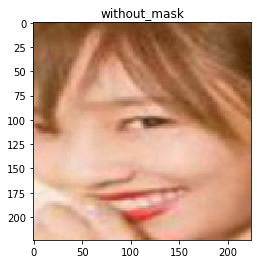

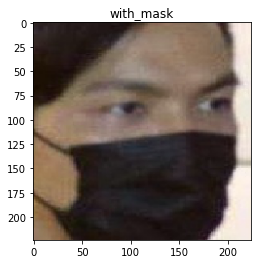

In [12]:
from keras.preprocessing.image import array_to_img
for i in range(2,8):
    #x=np.reshape(train_set[i],(224,224,3))
    x=train_set[i]
    x=array_to_img(x)
    xx=plt.imshow(x)
    plt.title(labels[i])
    plt.show()

In [13]:
print(len(train_set))
print(len(labels))

3833
3833


In [14]:
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical

X=np.array(train_set)
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
y=to_categorical(labels)
y=np.array(y)
print(X.shape)
print(y.shape)

(3833, 224, 224, 3)
(3833, 2)


In [15]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X,y,random_state=42,test_size=0.3,stratify=y)

In [16]:
print(x_train.shape)
print(y_val.shape)

(2683, 224, 224, 3)
(1150, 2)


In [17]:
del train_set,labels
del label1,label2

In [18]:
from keras.preprocessing.image import ImageDataGenerator
train_gen=ImageDataGenerator(
    rescale=1./255, #scaling image between 0 and 1
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
val_gen=ImageDataGenerator(rescale=1.0/255)

In [19]:
train_generator=train_gen.flow(x_train,y_train,batch_size=10)
valid_generator=val_gen.flow(x_val,y_val,batch_size=10)

In [20]:
from keras.applications.vgg19 import VGG19
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
opt=Adam(lr=0.0001)
mod=VGG19(include_top=False,weights="imagenet",input_shape=(224,224,3))
#mod.trainable=False
for layer in mod.layers:
    layer.trainable = False
model=mdl=keras.Sequential([
    mod,
    layers.Flatten(),
    layers.Dropout(rate=0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(2,activation='softmax')
])
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 23,236,034
Trainable params: 3,211,650
Non-trainable params: 20,024,384
_________________________________________________________________


In [21]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config=ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.8
config.gpu_options.allow_growth=True
session=InteractiveSession(config=config)

In [22]:
batch_size=50
n_train=len(x_train)
n_val=len(x_val)
history=model.fit(train_generator,
                  steps_per_epoch=n_train//batch_size,
                  epochs=30,
                  validation_data=valid_generator,
                  validation_steps=n_val//batch_size
                  
)

Epoch 1/30
53/53 [==============================] - 62s 826ms/step - loss: 0.6813 - accuracy: 0.5946 - val_loss: 0.3128 - val_accuracy: 0.8826
Epoch 2/30
53/53 [==============================] - 40s 762ms/step - loss: 0.3768 - accuracy: 0.8837 - val_loss: 0.2310 - val_accuracy: 0.9522
Epoch 3/30
53/53 [==============================] - 41s 766ms/step - loss: 0.3430 - accuracy: 0.8632 - val_loss: 0.1465 - val_accuracy: 0.9565
Epoch 4/30
53/53 [==============================] - 41s 767ms/step - loss: 0.2870 - accuracy: 0.8894 - val_loss: 0.1789 - val_accuracy: 0.9435
Epoch 5/30
53/53 [==============================] - 41s 768ms/step - loss: 0.2745 - accuracy: 0.9086 - val_loss: 0.1227 - val_accuracy: 0.9565
Epoch 6/30
53/53 [==============================] - 41s 769ms/step - loss: 0.2497 - accuracy: 0.9027 - val_loss: 0.1521 - val_accuracy: 0.9391
Epoch 7/30
53/53 [==============================] - 53s 997ms/step - loss: 0.2079 - accuracy: 0.9233 - val_loss: 0.1075 - val_accuracy: 0.9609

Minimum validation loss: 0.045
Maximum validation accuracy: 0.983


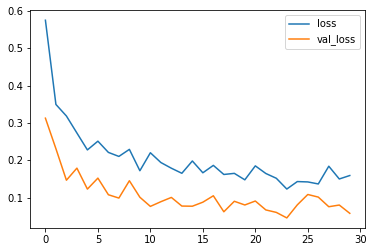

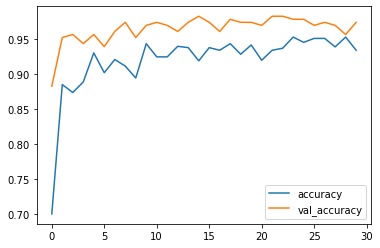

In [23]:
history_df= pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Minimum validation loss: {:.3f}".format(history_df['val_loss'].min()))
print("Maximum validation accuracy: {:.3f}".format(history_df['val_accuracy'].max()))

In [24]:
model.save_weights('vgg19_face_model_wieghts.h5')
model.save('vgg19_face_model_keras.h5')